In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
import pickle

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
import main

In [4]:
from config import load_data
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
binning = load_data('binning')

# Reproducing case-B Recombination Coefficients

In [5]:
rs_vec = 10**np.arange(1,4,.5)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)
length = len(rs_vec)

In [6]:
def alpha_recomb_full_Kot(T_over_rydberg):
    return (
        8.414*(np.log(1 + 1./T_over_rydberg) + 3.499) * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.6517*T_over_rydberg +   0.2138*T_over_rydberg**(3/2))
    )
def alpha_recomb_1_Kot(T_over_rydberg):
    return (
        17.41 * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.3593*T_over_rydberg**(7/6) + 0.1471*T_over_rydberg**(3/2))
    )

In [7]:
# Tm^1/2 * alpha_B from Hummer 1994 MNRAS
Tm_alphaB_Hummer = np.array([
    9.283e-11, 8.823e-11, 8.361e-11,
    7.898e-11, 7.435e-11, 6.973e-11,
    6.512e-11, 6.054e-11, 5.599e-11,
    5.147e-11, 4.700e-11, 4.258e-11,
    3.823e-11, 3.397e-11, 2.983e-11,
    2.584e-11, 2.204e-11, 1.847e-11,
    1.520e-11, 1.226e-11, 9.696e-12,
    7.514e-12, 5.710e-12, 4.257e-12,
    3.117e-12, 2.244e-12, 1.590e-12,
    1.110e-12, 7.642e-13, 5.199e-13,
3.498e-13])

#Convert to eV
Tm_Hummer = 10**np.arange(1,7.2,.2)*phys.kB

alphaB_Hummer = interp1d(Tm_Hummer, Tm_alphaB_Hummer/np.sqrt(Tm_Hummer/phys.kB))

In [8]:
%autoreload
# alpha_B requires many excited states to converge (see Hummer Fig. 1)
nmax = 100
Delta_f = lambda a : 0

alpha_tot=np.zeros(length)
alpha_tot_Hongwan=np.zeros(length)
for i, rs in enumerate(rs_vec):
    Tm = phys.Tm_std(rs)

#     k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
#     alpha = atomic.populate_alpha(Tm, phys.TCMB(rs)/1e20, nmax, k2_tab, g)
#     alpha_tot[i] = np.sum(alpha)
    alpha_tot_Hongwan[i] = bf.alpha_B(Tm,stimulated_emission=False, n=nmax)
    print(rs, alpha_tot_Hongwan[i])
    
#!!! Need to double-check the stimulated emission coefficient

10.0 5.5344162261919e-11
31.622776601683793 1.6591391903813432e-11
100.0 4.818262322528525e-12
316.22776601683796 1.685222912882534e-12
1000.0 7.118669108925685e-13
3162.2776601683795 2.9079485125257146e-13


In [9]:
if nmax==10:
    alpha_tot10 = alpha_tot.copy()
elif nmax==20:
    alpha_tot20 = alpha_tot.copy()
elif nmax==50:
    alpha_tot50 = alpha_tot.copy()
elif nmax==100:
    alpha_tot100 = alpha_tot.copy()
elif nmax==300:
    alpha_tot300 = alpha_tot.copy()

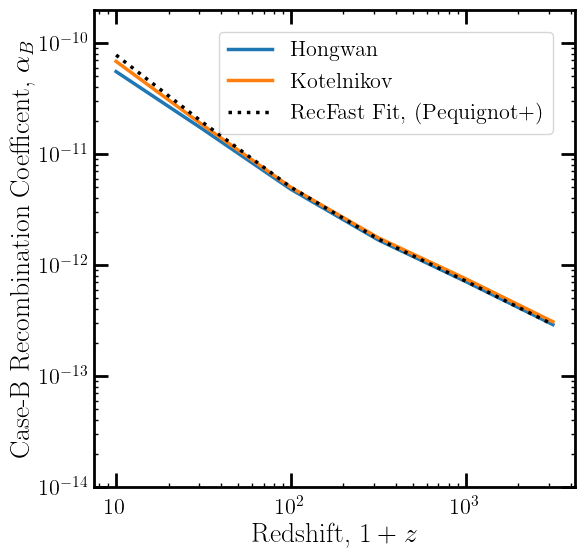

In [10]:
rs_vec = 10**np.arange(1,4,.5)
Tm_vec = phys.Tm_std(rs_vec)
plt.figure()
plt.loglog()
plt.ylim([1e-14,2e-10])

# plt.plot(rs_vec[Tm_vec>8e-4], alphaB_Hummer(Tm_vec[Tm_vec>8e-4]), label='Hummer 1994')

# plt.plot(rs_vec, alpha_tot10, label=r'DH, $n_{\mathrm{max}}=10$')
# plt.plot(rs_vec, alpha_tot20, label=r'DH, $n_{\mathrm{max}}=20$')
# plt.plot(rs_vec, alpha_tot50, label=r'DH, $n_{\mathrm{max}}=50$')
# plt.plot(rs_vec, alpha_tot100, label=r'DH, $n_{\mathrm{max}}=100$')
# plt.plot(rs_vec, alpha_tot300, label=r'DH, $n_{\mathrm{max}}=300$')

plt.plot(rs_vec, alpha_tot_Hongwan, label=r'Hongwan')

tmp = alpha_recomb_full_Kot(Tm_vec/phys.rydberg)-alpha_recomb_1_Kot(Tm_vec/phys.rydberg)
plt.plot(rs_vec, tmp, label=r'Kotelnikov')
plt.plot(rs_vec, phys.alpha_recomb(Tm_vec, 'HI')/1.125, label='RecFast Fit, (Pequignot+)', color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Case-B Recombination Coefficent, $\alpha_B$', fontsize=20)
plt.legend()

$\beta_B$ is obtained by detailed balance. 
First, use $x_i \beta_i \sim \frac1{g_i}e^{-E_i/T_m}\alpha_i$.
Next, assume $x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m}$. 
Finally, write the ionization term in the $x_e$ evolution equation as 
$$
\sum_i \beta_i x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m} \sim x_{2s}e^{-E_2/T_m} \alpha_B \sim \beta_B x_{2s}
$$
So a cross-cheeck of $\alpha_B$ is a cross-check of $\beta_B$.

# Deviations from TLA Assumptions

The TLA assumes that the excited states obey the detailed balance condition
$$
\begin{alignat}{1}
	\frac{x_i}{x_{2s}} = g_i e^{-(E_i-E_\alpha)/T} \, ,
\end{alignat}
$$
that the $n=2$ state obeys
$$
\begin{alignat}{1}
	x_2 = & \frac{x_{1s}e^{-E_\alpha/T} (3 R_{\text{Ly}\alpha} + \Lambda_{2s}) + x_e^2 n_H \alpha_\text{B}}{
	\frac34 R_{\text{Ly}\alpha} + \frac14 \Lambda_{2s} + \beta_\text{B}}   \, ,
\end{alignat}
$$
and that the substates satisfy 
$$
\begin{alignat}{1}
	x_{2p} = & \frac34 x_2 \\
    x_{2s} = & \frac14 x_2 \, .
\end{alignat}
$$

We also assume that the excited state abundances are so exponentially suppressed that $$x_{1s} = 1-x_e \, .$$
Let us now see if we can reproduce this behavior.

In [11]:
%autoreload
rs_vec  = 10**np.arange(1,4.55,.05)
Tr_vec  = phys.TCMB(rs_vec)
Tm_vec  = phys.Tm_std(rs_vec)

length  = len(rs_vec)

xe_vec  = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

In [12]:
def g_nl(l): return 2*l +1
def E(n): return phys.rydberg/n**2
hc = 2*np.pi*phys.hbar * phys.c

### Checking Detailed Balance

In [13]:
%autoreload

#Detailed Balance between recombination and ionization
rs = 3e3
Tr = phys.TCMB(rs)
Tm = Tr#phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3
x1s = phys.xHI_std(rs)

nmax=9
new_switch=True
R = atomic.populate_radial(nmax)
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

hplanck=2*np.pi*phys.hbar
lam_T = hplanck*phys.c/(2*np.pi * phys.mu_ep * Tr)**(1/2)

for n in np.arange(1,nmax+1):
    for l in np.arange(0,n):
        fac = np.exp(phys.rydberg/n**2/Tr)*g_nl(l)*lam_T**3
        if new_switch:
            fac *= ((1/2*phys.mu_ep*phys.alpha**2)/phys.rydberg)**(3/2)
        
        print(n,l,':', beta[n][l]/alpha[n][l] * fac)

1 0 : 0.9999999999999992
2 0 : 1.0
2 1 : 0.9999999999999999
3 0 : 1.0000000000000004
3 1 : 1.0000000000000002
3 2 : 1.0000000000000004
4 0 : 1.0000000000000004
4 1 : 1.0000000000000004
4 2 : 1.0000000000000004
4 3 : 1.0000000000000004
5 0 : 1.0000000000000002
5 1 : 1.0000000000000002
5 2 : 1.0000000000000007
5 3 : 1.0
5 4 : 0.9999999999999997
6 0 : 1.0000000000000002
6 1 : 1.0000000000000004
6 2 : 1.0000000000000004
6 3 : 1.0000000000000004
6 4 : 1.0000000000000002
6 5 : 1.0000000000000007
7 0 : 1.0000000000000004
7 1 : 1.0000000000000004
7 2 : 1.0000000000000002
7 3 : 1.0000000000000004
7 4 : 1.0
7 5 : 1.0000000000000007
7 6 : 1.0
8 0 : 1.0000000000000002
8 1 : 1.0
8 2 : 1.0000000000000004
8 3 : 1.0000000000000004
8 4 : 1.0000000000000007
8 5 : 1.0000000000000004
8 6 : 1.0000000000000004
8 7 : 1.0
9 0 : 0.9999999999999997
9 1 : 0.9999999999999999
9 2 : 0.9999999999999997
9 3 : 0.9999999999999998
9 4 : 0.9999999999999998
9 5 : 1.0
9 6 : 1.0
9 7 : 1.0000000000000002
9 8 : 1.000000000000

In [14]:
%autoreload
#Saha equilibrium

rhs = lam_T**-3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/Tr)
phys.xHI_std(rs) * rhs/xe**2

0.9999999999999999

In [15]:
#The main discrepancy comes from the fact that 
#this quantity doesn't keep track of stimulated emission

phys.alpha_recomb(Tr,'HI')/1.125

3.0443848773825195e-13

In [16]:
bf.alpha_B(Tr, T_r=Tr, stimulated_emission=False, f_gamma=None, n=100)

3.035234831208717e-13

In [17]:
bf.alpha_B(Tr, T_r=Tr, stimulated_emission=True, f_gamma=None, n=100)

8.381778979913012e-13

In [18]:
%autoreload
lam_T = hc/(2*np.pi * phys.mu_ep * Tr)**(1/2)
bf.beta_B(Tr,100) * np.exp(phys.rydberg/4 / Tr)*lam_T**3 * 4

8.381778979913006e-13

In [19]:
# The main discrepancy comes from stimulated emission
bf.beta_B(Tr,300)

3895924.5018236106

In [20]:
phys.beta_ion(Tr,'HI')

1226147.2466890754

In [21]:
# Detailed Balance amongst the bound-bound transition rates
print('n1 l n2')
n1,l = 1,0
for n2 in np.arange(2,nmax+1):
    Ennp = E(n1)-E(n2)
    print(n1,'',l,n2,':',
          BB['up'][n1][n2][l]/(BB['dn'][n2][n1][l+1])/(
         np.exp(-Ennp/Tr)*g_nl(l+1)/g_nl(l)))
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
1  0 2 : 1.0000000000000002
1  0 3 : 1.0000000000000002
1  0 4 : 0.9999999999999999
1  0 5 : 0.9999999999999998
1  0 6 : 0.9999999999999999
1  0 7 : 1.0000000000000002
1  0 8 : 1.0
1  0 9 : 0.9999999999999998
3  1 2 : 1.0
4  1 2 : 1.0
4  1 3 : 1.0
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999991
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999998
5  3 4 : 1.0000000000000002
6  1 2 : 1.0000000000000002
6  1 3 : 1.0
6  2 3 : 0.9999999999999999
6  1 4 : 1.0
6  2 4 : 1.0
6  3 4 : 1.0
6  1 5 : 1.0
6  2 5 : 0.9999999999999997
6  3 5 : 1.0
6  4 5 : 0.9999999999999999
7  1 2 : 1.0
7  1 3 : 1.0
7  2 3 : 0.9999999999999999
7  1 4 : 0.9999999999999999
7  2 4 : 1.0
7  3 4 : 1.0
7  1 5 : 1.0000000000000002
7  2 5 : 1.0
7  3 5 : 1.0000000000000004
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0000000000000002
7  3 6 : 1.0000000000000002
7  4 6 : 1.0
7  5 6 : 1.0000000000000002
8  1 2 : 0.9999999999999999
8  1 3 : 0.9999

In [22]:
print('n1 l n2')
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
3  1 2 : 1.0
4  1 2 : 1.0
4  1 3 : 1.0
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999991
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999998
5  1 4 : 1.0
5  2 4 : 0.9999999999999998
5  3 4 : 1.0000000000000002
6  1 2 : 1.0000000000000002
6  1 3 : 1.0
6  2 3 : 0.9999999999999999
6  1 4 : 1.0
6  2 4 : 1.0
6  3 4 : 1.0
6  1 5 : 1.0
6  2 5 : 0.9999999999999997
6  3 5 : 1.0
6  4 5 : 0.9999999999999999
7  1 2 : 1.0
7  1 3 : 1.0
7  2 3 : 0.9999999999999999
7  1 4 : 0.9999999999999999
7  2 4 : 1.0
7  3 4 : 1.0
7  1 5 : 1.0000000000000002
7  2 5 : 1.0
7  3 5 : 1.0000000000000004
7  4 5 : 1.0000000000000002
7  1 6 : 1.0000000000000002
7  2 6 : 1.0000000000000002
7  3 6 : 1.0000000000000002
7  4 6 : 1.0
7  5 6 : 1.0000000000000002
8  1 2 : 0.9999999999999999
8  1 3 : 0.9999999999999998
8  2 3 : 1.0
8  1 4 : 1.0000000000000002
8  2 4 : 1.0
8  3 4 : 1.0
8  1 5 : 0.9999999999999998
8  2 5 : 0.9999999999999999
8  3 5 : 1.0
8  4 5 : 1.0
8  1 6 : 1.0000000000000002
8  2 6 : 1.00000000

In [23]:
#Saha equilibrium at large redshift between xe = xHII and x1s ~ xHI
hc = 2*np.pi * phys.hbar*phys.c
mu_e = phys.me/(1+phys.me/phys.mp)
lam_T = hc/(2*np.pi * mu_e*Tr_vec)**(1/2)

(phys.xHI_std(rs_vec)/nH_vec/xe_vec**2)*np.exp(-E(1)/Tr_vec)/g_nl(0)/lam_T**3

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.43327872e-290, 7.32458855e-256,
       2.80903834e-225, 4.94346386e-198, 9.19981390e-174, 3.80944117e-152,
       6.80923757e-133, 9.48013312e-116, 1.73886686e-100, 6.70430618e-087,
       8.24886760e-075, 4.69550501e-064, 1.71502998e-054, 5.38791605e-046,
       1.88080156e-038, 9.14825733e-032, 7.53729903e-026, 1.23285450e-020,
       4.43382508e-016, 3.55145326e-012, 5.39195863e-009, 1.11790076e-006,
       5.60405490e-005, 1.61963506e-003, 3.50690809e-002, 4.25222434e-001,
       1.02684136e+000, 1.02381617e+000, 1.01976238e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1

In [24]:
# Undetailed balance: Seeing that each line of the MLA is satisfied 
# by x_i in LTE

num_states = int((n+1)*n/2)
states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_lte = np.zeros(num_states)
x_lte[0] = x1s
for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]
    x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s

diff_vec = np.zeros(num_states)

def nl_vec(n,l):
    return int((n-1)*n/2)+l

# x_tmp = np.zeros(num_states)
# x_tmp[0] = x1s

# for nl in np.arange(1, num_states):
#     n = states_n[nl]
#     l = states_l[nl]
#     x_tmp[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x_tmp[0]
    

for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
    if nl != num_states-1:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['dn'][1:,n,l+1]/R_tot*x_lte[np.array([nl_vec(n,l+1) for n in np.arange(1,nmax+1)])]
            +BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
    else:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
        
    if nl==1:
#         diff_vec[nl] -= BB['dn'][2,1,0]/R_tot*x_lte[1]
        diff_vec[nl] += BB['dn'][2,1,0]*np.exp((E(2)-E(1))/Tr)/R_tot*x_lte[0]
        
    print(n,l,diff_vec[nl]/x_lte[nl])
    
print(np.linalg.norm(diff_vec)/np.linalg.norm(x_lte))

2 0 4.668917149747172e-16
2 1 5.3612157280822e-16
3 0 -1.1158988923751275e-15
3 1 -1.9122211066522137e-16
3 2 -1.167764615541859e-15
4 0 2.1687042314226585e-15
4 1 4.953213368064096e-16
4 2 1.9277370945979186e-15
4 3 2.5186803110966856e-15
5 0 4.960016261403872e-16
5 1 0.0
5 2 3.1000101633774196e-16
5 3 7.085737516291245e-17
5 4 -3.6511230813111836e-16
6 0 5.887032742429433e-16
6 1 -1.700698347812947e-16
6 2 -3.139750795962364e-16
6 3 -2.466947053970429e-16
6 4 1.875128947588634e-16
6 5 9.365733908410462e-16
7 0 -2.5337429841951354e-15
7 1 -9.0490820864112e-16
7 2 -2.9138044318244054e-15
7 3 -3.024978868886029e-15
7 4 -2.825324518090608e-15
7 5 -2.5748751754970043e-15
7 6 -2.4067077933666706e-15
8 0 -4.962096541070434e-17
8 1 -9.924193082140867e-17
8 2 -7.343902880784242e-16
8 3 -2.55193536397908e-16
8 4 -7.71881684166512e-17
8 5 2.7065981133111455e-16
8 6 8.397394146426888e-16
8 7 6.798072261266494e-16
9 0 1.2687103641443744e-15
9 1 1.7620977279782976e-17
9 2 7.189358730151454e-16
9 3

In [25]:
nmax=10
skip=1

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

H_engs = atomic.get_transition_energies(nmax)
num_lines = H_engs.size-1

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s

beta_MLA = np.zeros(length)
alpha_MLA = np.zeros(length)

new_switch = True

for i in np.arange(0,length,skip):#(-1,0):#(0,length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    mat = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
#         print(rs, xe**2 * alpha[n][l]*nH)
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            mat[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] += xe**2 * nH * alpha[n][l]
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0]
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
            
        b[nl] /= tot_rate

    #Probability matrix for only the excited states
    M = ident - mat[1:,1:]
    
    x_vec[i] = np.linalg.solve(M,b[1:])
    x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
    
    for nl in np.arange(num_states):
        n, l = states_n[nl], states_l[nl]
        if nl > 0:
            beta_MLA[i]  += x_full[nl] * beta[n][l]
            alpha_MLA[i] += alpha[n][l] * xe**2 * nH

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_1877/3211682970.py:63: RuntimeWarning: divide by zero encountered in true_divide
  mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate
/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_1877/3211682970.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  mat[0][1] = BB['dn'][2][1][0]/ tot_rate
/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_1877/3211682970.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  b[nl] /= tot_rate


$$
4\mathcal{C} \beta_B x_{1s} e^{-E_\alpha /T} = \beta_{MLA}
$$

In [26]:
ion_TLA = np.zeros(length)
ion_Hongwan_noSE = np.zeros(length)
ion_Hongwan = np.zeros(length)
# nmax = 20

for i,Tr in enumerate(rs_vec):
    rs = rs_vec[i]
    x2 = x2_vec[i]
    Tr = Tr_vec[i]
    
    ion_TLA[i] = phys.beta_ion(Tr,'HI') * x2
    
    #Detailed Balance factor
    lam_T = hc/np.sqrt(2*np.pi*phys.mu_ep*Tr)
    db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4
    ion_Hongwan_noSE[i] = bf.alpha_B(Tr, T_r=Tr, stimulated_emission=False, f_gamma=None, n=nmax)/db_fac * x2
    
    ion_Hongwan[i] = bf.beta_B(Tr,nmax) * x2
    
#     print(rs, " Done")

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_1877/2850875621.py:15: RuntimeWarning: overflow encountered in exp
  db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4


Text(0.5, 1.0, 'Modifications to $\\beta_B$')

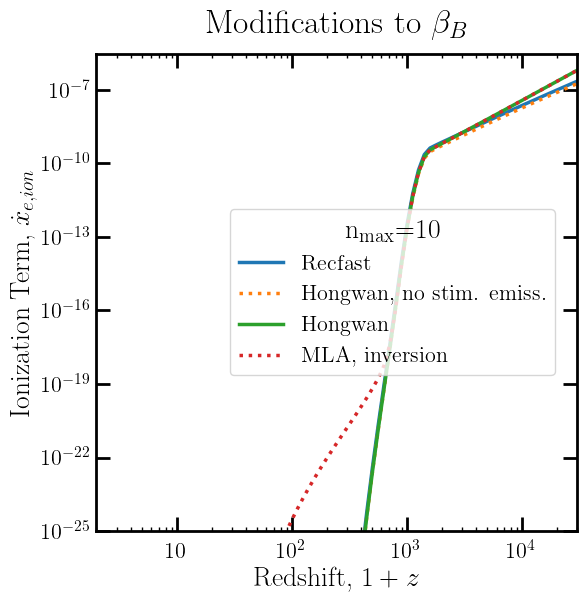

In [27]:
plt.figure()
plt.loglog()
plt.axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

plt.plot(rs_vec,ion_TLA, label='Recfast')
plt.plot(rs_vec,ion_Hongwan_noSE, label='Hongwan, no stim. emiss.', linestyle=':')
plt.plot(rs_vec,ion_Hongwan, label='Hongwan')
plt.plot(rs_vec,beta_MLA, label='MLA, inversion', linestyle=':')

plt.legend(fontsize=12)
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Ionization Term, $\dot{x}_{e,ion}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Modifications to $\beta_B$')

Text(0.5, 1.0, 'Modifications to $\\alpha_B$')

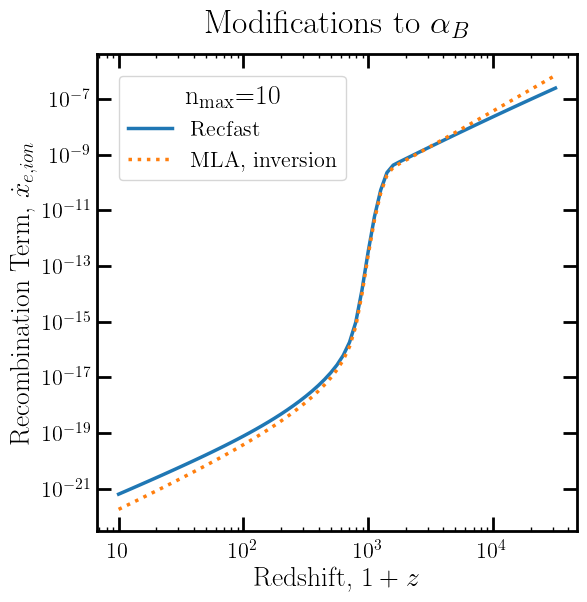

In [28]:
plt.figure()
plt.loglog()
# plt.axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

plt.plot(rs_vec,phys.alpha_recomb(Tm_vec,'HI')*nH_vec*xe_vec**2, label='Recfast')
# plt.plot(rs_vec,ion_Hongwan_noSE, label='DH, no stim. emiss.')
# plt.plot(rs_vec,ion_Hongwan, label='DH')
plt.plot(rs_vec,alpha_MLA, label='MLA, inversion', linestyle=':')

plt.legend()
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Recombination Term, $\dot{x}_{e,ion}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Modifications to $\alpha_B$')

In [29]:
#initialize
E_current = 0
ind_current = 0
H_engs = np.zeros((int) (nmax*(nmax-1)/2))
Nphot_cascade = H_engs.copy()

nB = phys.nB*rs_vec[i]**3


for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]

    # If this state has a new energy, add to the list of photon energies
    # Add nmax-n more indices, you'll end up with nmax(nmax-1)/2
    if E_current != E(n):

        #Start by filling from 0 to nmax-1
        if n>1:
            ind_current += nmax-n+1

        E_current = E(n)
        H_engs[ind_current:ind_current + nmax-n] = E(n)-E(np.arange(n+1,nmax+1))


    # photons from l <-> l+1 transitions
    if l<nmax-1:
        # Number of photons injected per baryon, per second
        Nphot_cascade[ind_current:ind_current + nmax-n] += nH_vec[i]*(
            x_full[(states_l == l+1) * (states_n>n)] * BB['dn'][n+1:,n,l+1] #Downscattering adds photons
            -x_full[nl] * BB['up'][n,n+1:,l] #upscattering subtracts them
        )/nB
        
    #NOTE: 'dn' and 'up' have nothing to do with down- or up-scattering, 
    # just if the l quantum number go up or down
    
    # photons from l <-> l-1 transitions
    if l>0:
        Nphot_cascade[ind_current:ind_current + nmax-n] += nH_vec[i] * ( 
            x_full[(states_l == l-1) * (states_n>n)] * BB['up'][n+1:,n,l-1] #Downscattering
            -x_full[nl] * BB['dn'][n,n+1:,l] #upscattering
        )/nB
        
# Make a spectrum
data = np.array(sorted(np.flipud(np.transpose([H_engs,Nphot_cascade])), key=lambda pair:pair[0]))
       
# Then add the two photon transitions
#!!! Tm or Tr in detailed balance?
amp_2s1s = BB['dn'][2,1,0] * (x_full[1] - x_full[0]*np.exp(-phys.lya_eng/phys.TCMB(rs)))
spec_2s1s = spectools.discretize(binning['phot'], phys.dNdE_2s1s)
spec_2s1s.switch_spec_type()

transition_spec = Spectrum(data[:,0], data[:,1], spec_type='N')
transition_spec.rebin(binning['phot'])
transition_spec.N += amp_2s1s * spec_2s1s.N

Text(0.5, 1.0, 'Distortion from Atomic Transitions')

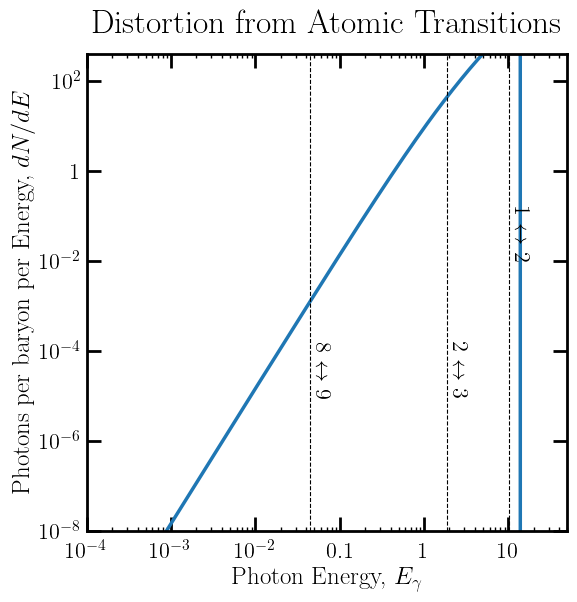

In [31]:
plt.figure()
plt.axis([1e-4,50, 1e-8, 4])
plt.loglog()
eng = transition_spec.eng
plt.plot(transition_spec.eng, eng*transition_spec.N*1e16)

plt.axvline(E(2)-E(3), linewidth=0.8, color='k', linestyle='--')
plt.text((E(2)-E(3))*1.02, 1e-5, r'2 $\leftrightarrow$ 3', fontsize=16.0, rotation=270)

plt.axvline(E(8)-E(9), linewidth=0.8, color='k', linestyle='--')
plt.text((E(8)-E(9))*1.02, 1e-5, r'8 $\leftrightarrow$ 9', fontsize=16.0, rotation=270)


plt.axvline(E(1)-E(2), linewidth=0.8, color='k', linestyle='--')
plt.text((E(1)-E(2))*1.02, 1e-2, r'1 $\leftrightarrow$ 2', fontsize=16.0, rotation=270)

# plt.axvline(E(2)-E(3), linewidth=1.0, color='k', linestyle='--', label='n=2 to 3')

plt.xlabel(r'Photon Energy, $E_{\gamma}$')
plt.ylabel(r'Photons per baryon per Energy, $dN/dE$')
plt.title('Distortion from Atomic Transitions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

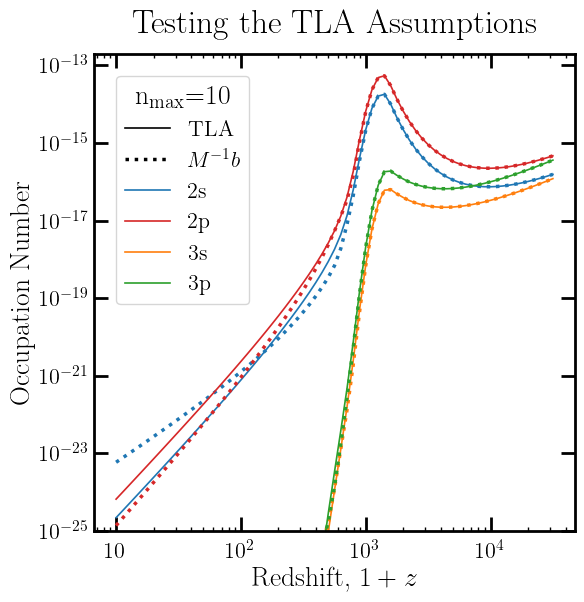

In [32]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

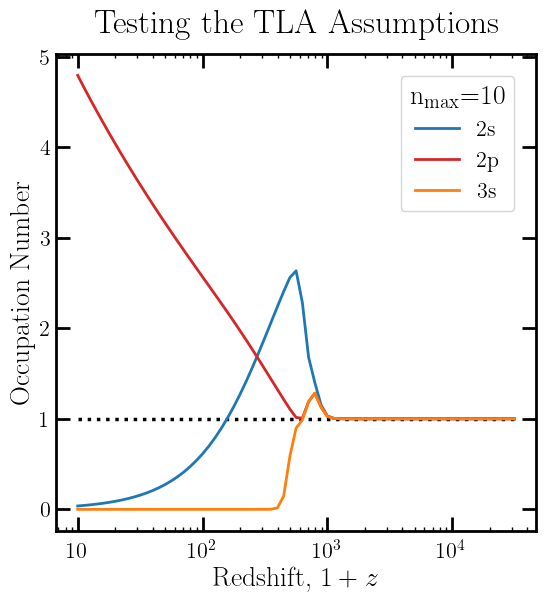

In [33]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

## Hyrec Comparison

Try to reproduce Hyrec Fig. 3

In [34]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
lifetime=1e50
species = 'phot'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 200

In [229]:
%autoreload
hyrec_test = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=16, backreaction=False, distort=True,
#     struct_boost=struct_boost,
#     helium_TLA=False,
    end_rs=1e3,
    rtol=1e-3
)

  0%|          | 0/69.0 [00:00<?, ?it/s]

3000.0 1.002408986981389 1.0024089980214284
2952.381960165853 0.9972527513686521 0.9968126079583078
2905.5197462375904 0.9921512838186669 0.9913577754423242
2859.4013612325116 0.9871067531454093 0.9857185370309768
2814.014998592186 0.9821126938810485 0.9803942152649553
2769.349039159905 0.9771715838122352 0.9753200526047223
2725.392048206116 0.9722824024739776 0.9703620969450057
2682.132772501069 0.9674461854391826 0.9654594507173838
2639.560137433929 0.9626611033229957 0.960607341686217
2597.663244177613 0.9579248466520127 0.952705898046875
2556.4313668986315 0.9532400633841424 0.9485736780296935
2515.8539500112197 0.9486045835215675 0.945409051238036
2475.920605475045 0.9440179702954047 0.9423169633732433
2436.6211101358144 0.9394794331038163 0.9377833361617274
2397.9454031080927 0.9349892959879533 0.9333590473810501
2359.883583199658 0.9305456162660115 0.9290566398901579
2322.4259063767427 0.9261486392750881 0.9244724027228667
2285.5627832695104 0.9217965331165956 0.9201526762306261

/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1556.768640476819 0.8299375661332034 0.8292070833189222
1532.0585500985615 0.8266077298161864 0.8241106486913247
1507.740675076283 0.8232954696819084 0.8187636762664651
1483.808789901169 0.8200200317169908 0.8133585862106569
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1468937791319D+04   r2 = -0.1088476084113D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1468937791319D+04   r2 = -0.1088476084113D-12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1468937791319D+04   r2 = -0.5442380420565D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are 

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:152: RuntimeWarning: invalid value encountered in double_scalars
  return (1-np.exp(-tau))/tau


1460.2567678799128 0.8166849250323238 nan
1437.0785795662512 nan nan


ValueError: Encountered nan in Tm or x

In [606]:
ind=0
x2s_func = interp1d(rs_vec, x2s_vec)
rs_tmp = hyrec_test['rs'][ind]
print(
#     bf.alpha_nl(2, 1, hyrec_test['Tm'][ind], T_r=phys.TCMB(rs_tmp), f_gamma=None, stimulated_emission=True),
#     bf.beta_nl(2, 1, T_r=phys.TCMB(rs_tmp)),
    x2s_func(rs_tmp)
)

9.605455101120964e-15


In [60]:
%autoreload
fudge = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=True,
    end_rs=end_rs
)

  0%|          | 0/170.0 [00:00<?, ?it/s]

In [61]:
%autoreload
baseline = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=False,
    end_rs=end_rs
)

  0%|          | 0/170.0 [00:00<?, ?it/s]

Comment everything better

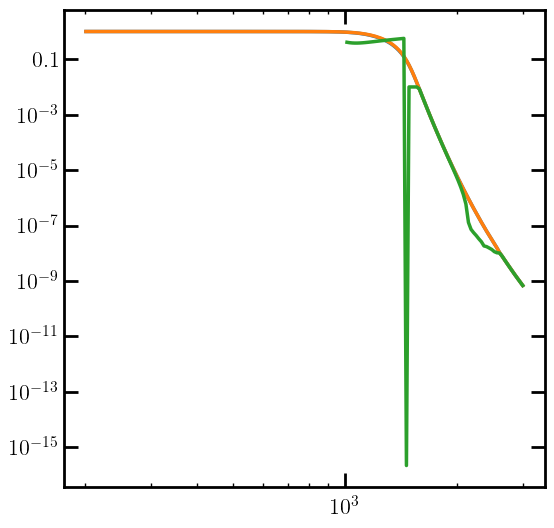

In [230]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

rtol=1e-4 -> 1e-10

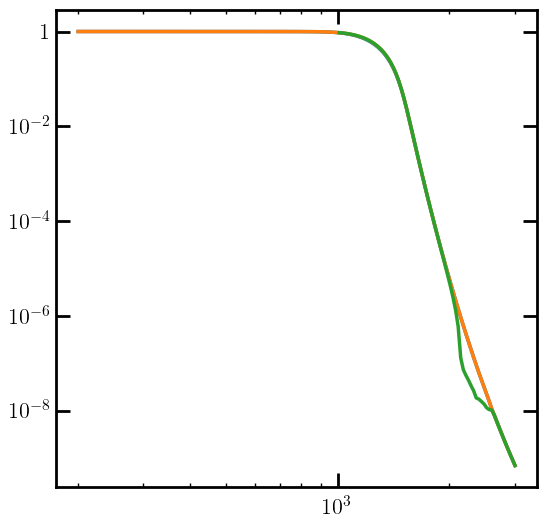

In [207]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

If we use $C(\alpha - \beta)$ (rather than Saha) from rs=3e3

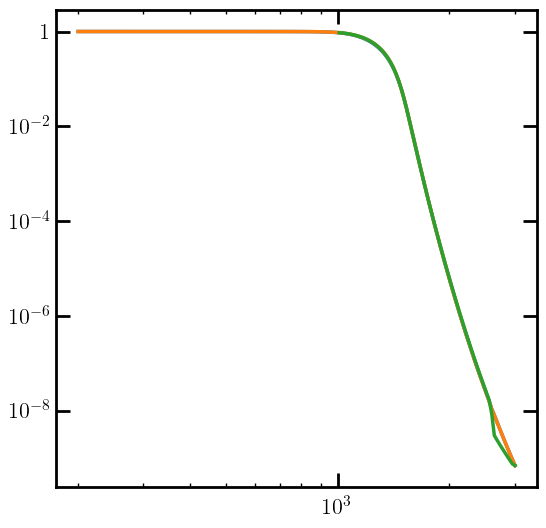

In [192]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

If we use $\alpha - \beta \, x_2$ (rather than Saha) from rs=3e3

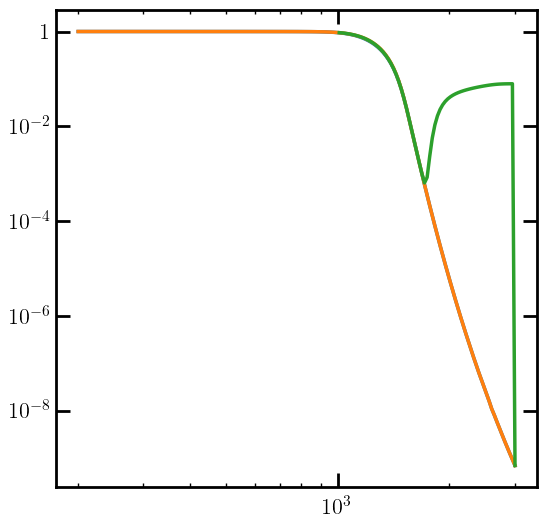

In [188]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

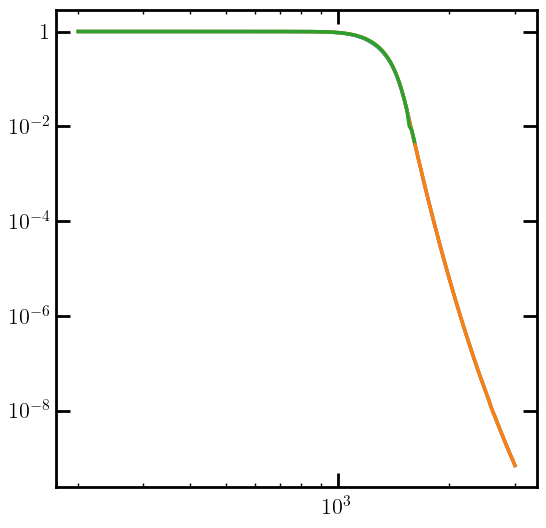

In [167]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

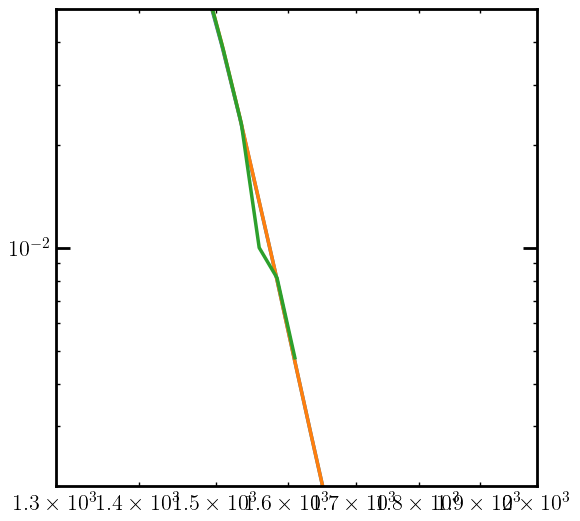

In [166]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], 1-baseline['x'][:,0])
plt.plot(fudge['rs'], 1-fudge['x'][:,0])
plt.plot(hyrec_test['rs'], 1-hyrec_test['x'][:,0])

For the Recfast comparison:
- We have to be very careful about where the fudge factors are, since there's one explicitly in $\alpha$, one implicitly in $\beta$ since we calculate it using detailed balance on $\alpha$, and one in $\mathcal{C}$ since it uses $\beta$.  Once all of these are accounted for we get agreement, otherwise we don't.
- We must use a fudge factor of 1.14 to compare to Fig 3 of Hyrec, not our default of 1.125

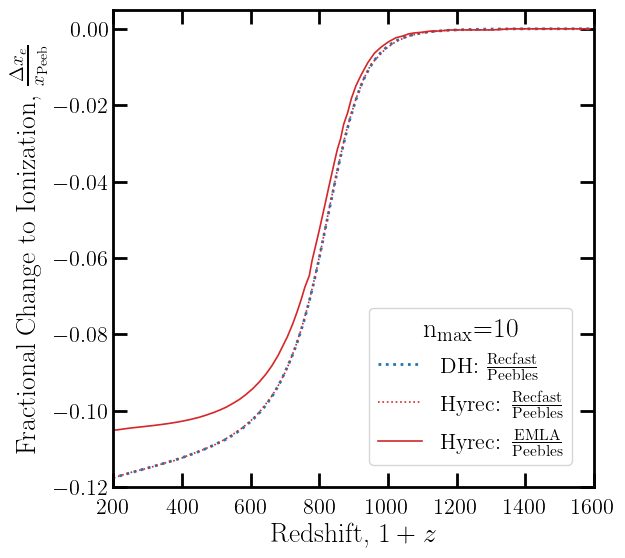

In [68]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.005])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
# plt.plot(test_main['rs'], hyrec_test['x'][:,0]/baseline['x'][:,0]-1, label='MLA, inverter')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

In [46]:
import csv

with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

In [68]:
def compton_cooling_rate(xHII, T_m, rs):
    xe = xHII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

In [123]:
def tmp_tla(rs_vec, init, alpha_tmp, beta_tmp, mxstep=1000, rtol=1e-6):
    
    def xHII(yHII):
        return 0.5 + 0.5*np.tanh(yHII)

    def derivs(rs, var):
        nH = phys.nH*rs**3

        def dlogT_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)
            xHI = 1 - xHII(yHII)

            adiabatic_cooling_rate = 2 * T_m/rs

            return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
                phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), T_m, rs
                    )
                )
            )/ (3/2 * nH * (1 + phys.chi + xe))

        def dyHII_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                return 0

            if xHII(yHII) > 0.99 and rs > 2000:
                # Use the Saha value. 
                return 2 * np.cosh(yHII)**2 * phys.d_xe_Saha_dz(rs, 'HI')

            ne = xe * nH
            xHI = 1 - xHII(yHII)

            return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                -(alpha_tmp * xHII(yHII) * xe * nH - beta_tmp)
            )

        log_T_m, yHII = var[0], var[1]

        return [
            dlogT_dz(yHII, log_T_m, rs),
            dyHII_dz(yHII, log_T_m, rs)
        ]


    
    soln = odeint(
        derivs, init, rs_vec,
        mxstep = mxstep, tfirst=True, rtol=rtol
    )

    return soln

In [141]:
ind1=5

start_rs = rs_vec[-ind1]
data=np.zeros((length-(ind1-1),2))
data[-1] = np.array([
    np.log(phys.Tm_std(start_rs)), 
    np.arctanh(2*(phys.xHII_std(start_rs) - 0.5))
])

lim = 5
for k in np.arange(lim):
    x2 = x2_vec[-ind1-k]
    Tr = Tr_vec[-ind1-k]
    Tm = Tm_vec[-ind1-k]
    
    beta_tmp  = phys.beta_ion(Tr,'HI') * x2
    alpha_tmp = phys.alpha_recomb(Tm, 'HI')/1.125
    
    rs_diff = rs_vec[-ind1-k:-ind1-(k+2):-1]
    
    soln = tmp_tla(rs_diff, data[-1-k], alpha_tmp, beta_tmp)
    
    data[-2-k] = soln[-1]
    
data[:,0] = np.exp(data[:,0])/phys.kB
data[:,1] = 0.5 + 0.5*np.tanh(data[:,1])

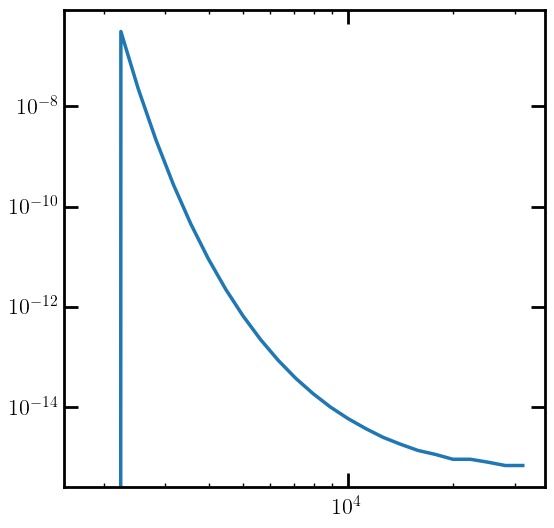

In [127]:
plt.figure()
plt.loglog()
plt.plot(rs_vec[-1-lim:], 1-data[-1-lim:,1])


In [ ]:
# Number of attempts before giving up. 
    N_attempts = 0
    # Flag to determine if solution was reached.
    solved     = False

    # List of indices (m_m, Q) where the solution failed. 
    error_arr = [] 

    while (not solved) and (N_attempts < 3):
        # Keep attempting until solved or we've tried twice. 

        try:

            N_attempts += 1

            # Solve using solve_ivp. 
            soln = solve_ivp(
                to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
                method='BDF', t_eval=rs_vec, 
                rtol=_rtol, max_step=_max_step
            )

        except:
            # solve_ivp returned an error. Adjust the tolerance
            # and step size and try again. 

            _rtol /= 1.2
            _max_step /= 1.5

        else:
            # solve_ivp completed successfully. However, we still need to check
            # that the solution managed to integrate over the entire redshift range,
            # and that there are no NaNs in the solution.
            if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():

                solved = True

    if not solved:
        # If solution fails, simply return False. 
        soln = False

    return soln

# Linear Algebra for Distortion

# Distortion

In [949]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [950]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

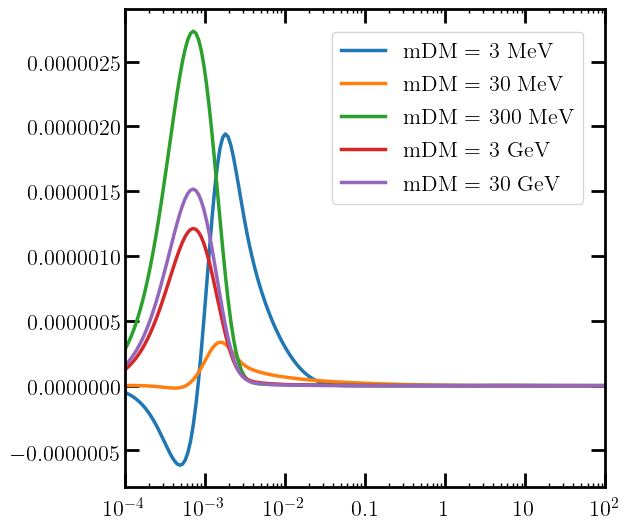

In [951]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()